## Mean SpeedNorm by Box grouped by Track and Distance

The shape, surface, and where the box lies along the track all appear to affect the speed of a greyhound. A greyhound could run the same distance at two distinct tracks, and run significantly different speeds to these factors.

Therefore, the performance (speed) of a greyhound must be normalised relative to that particular Track and Distance. We determine the z-score for each greyhound's speed at each Track and Distance, then take the average SpeedNorm by Track, Distance, and Box in order to determine the 'speed value' of each box.

Regardless of TrackDist, Boxes 1, 2, and 8 are generally the best boxes whereas Boxes 3, 4, 5, 6 are the less favourable boxes. No doubt this is due to the additional interference at the start of the race from neighbours. Although, if a greyhound has a relative faster starting acceleration, it has a good chance of escaping the interference.

Two things in particular should be noted:
- Weather can affect the speed of a greyhound, can we determine a way to account for weather variance across our data?
- Even though our sample sizes are large, there is 'some' data leakage here into the test set. If we want to prevent this we would have to do the below process but only across the races in the training set (or even better, time shift the below analysis for each race).

----

### 0. Read cleansed data

In [1]:
import os
import decouple
config = decouple.AutoConfig(' ')
os.chdir(config('ROOT_DIRECTORY'))
import sys
sys.path.insert(0, '')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import zscore

pd.set_option('display.max_columns', None)

# Read in data
df_raw = pd.read_csv('./data/clean/dog_results.csv')

display(df_raw)

,FastTrack_DogId,Place,DogName,Box,Rug,Weight,StartPrice,Margin1,Margin2,PIR,Checks,SplitMargin,RunTime,Prizemoney,FastTrack_RaceId,TrainerId,TrainerName,Distance,RaceGrade,Track,RaceNum,TrackDist,date_dt,win
0,157500927,1.0,RAINE ALLEN,1,1,27.4,2.4,2.30,NaN,Q/111,0,6.68,28.66,0.0,335811282,7683,C GRENFELL,500,Restricted Win,Bendigo,1,Bendigo500,2018-07-01,1
1,1820620018,2.0,SURF A LOT,2,2,32.8,6.3,2.30,2.30,M/332,0,7.01,28.82,0.0,335811282,137227,C TYLEY,500,Restricted Win,Bendigo,1,Bendigo500,2018-07-01,0
2,1950680026,3.0,PINGIN' BEE,6,6,25.5,9.3,3.84,1.54,S/443,0,7.24,28.93,0.0,335811282,132763,P DAPIRAN,500,Restricted Win,Bendigo,1,Bendigo500,2018-07-01,0
3,1524380048,4.0,LUCAS THE GREAT,7,7,32.2,9.1,5.27,1.43,M/655,5,7.31,29.03,0.0,335811282,116605,E HAMILTON,500,Restricted Win,Bendigo,1,Bendigo500,2018-07-01,0
4,124225458,5.0,QUAVO,4,4,28.9,3.4,5.56,0.29,M/766,8,7.38,29.05,0.0,335811282,132763,P DAPIRAN,500,Restricted Win,Bendigo,1,Bendigo500,2018-07-01,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
743127,329750694,4.0,SAIL BYE,7,7,30.6,3.9,3.75,1.86,NaN,0,NaN,20.33,85.0,723558817,17101,G MONKMAN,366,Masters Grade 5,Capalaba,10,Capalaba366,2021-10-31,0
743128,315222694,5.0,NAME HIM COOPER,5,5,29.2,19.0,4.75,1.00,NaN,0,NaN,20.40,10.0,723558817,61147,J HENZELL,366,Masters Grade 5,Capalaba,10,Capalaba366,2021-10-31,0
743129,327379998,6.0,MR. CHANGRETTA,4,4,31.4,51.0,5.00,0.14,NaN,0,NaN,20.41,10.0,723558817,61184,K RAINES,366,Masters Grade 5,Capalaba,10,Capalaba366,2021-10-31,0
743130,257638278,7.0,BEAR ZAR,2,2,38.3,71.0,5.25,0.14,NaN,0,NaN,20.42,10.0,723558817,62079,K BUTLER,366,Masters Grade 5,Capalaba,10,Capalaba366,2021-10-31,0


### Determine mean SpeedNorm by TrackDist and Box, and then take only TrackDist with a large enough sample size

In [6]:
# Copy dataframe
df = df_raw.copy()

# Calculate the average speed of greyhound for each race
df["Speed"] = df["Distance"]/df["RunTime"]

# Normalise the speed by track and distance
df["SpeedNorm"] = df.groupby("TrackDist")["Speed"].transform(lambda x: zscore(x))

# Group by track, distance, box and aggregate number of box runs and average
df = df.groupby(["TrackDist", "Box"], as_index=False).agg(SpeedNorm_mean=('SpeedNorm', 'mean'),
                                                          SpeedNorm_std=('SpeedNorm', 'std'),
                                                          SampleSize=('Box', 'count'))

# Take only trackdist with a large enough sample size
df["MinSampleSize"] = df.groupby("TrackDist")["SampleSize"].transform(lambda x: min(x))
df = df[df["MinSampleSize"] >= 1500]

display(df)

,TrackDist,Box,SpeedNorm_mean,SpeedNorm_std,SampleSize,MinSampleSize
0,Albion Park331,1,0.180995,0.923960,2076,1883
1,Albion Park331,2,0.104013,0.973405,2043,1883
2,Albion Park331,3,-0.041051,0.999312,2018,1883
3,Albion Park331,4,-0.075867,1.139908,2046,1883
4,Albion Park331,5,-0.052131,0.924933,1883,1883
...,...,...,...,...,...,...
978,Warragul460,4,-0.045738,0.963956,1933,1666
979,Warragul460,5,-0.101382,0.997376,1666,1666
980,Warragul460,6,-0.031941,0.999940,1878,1666
981,Warragul460,7,-0.027298,0.989042,1940,1666


### Plot mean SpeedNorm by Box for each TrackDist

It's not a surprise that generally boxes 1, 2, and 8 are the favourable boxes. They have a lower chance of getting interference with other greyhounds at the start of the race (this does depend on a greyhound's starting acceleration). 

Interestingly, some TrackDist's strongly favour a box while other's not so much. For example, Albion Park 395m has a average SpeedNorm of ~0.25 for Box 1, whereas Shepparton 450m has an average SpeedNorm close to zero for Box 1.

<AxesSubplot:xlabel='Box', ylabel='SpeedNorm_mean'>

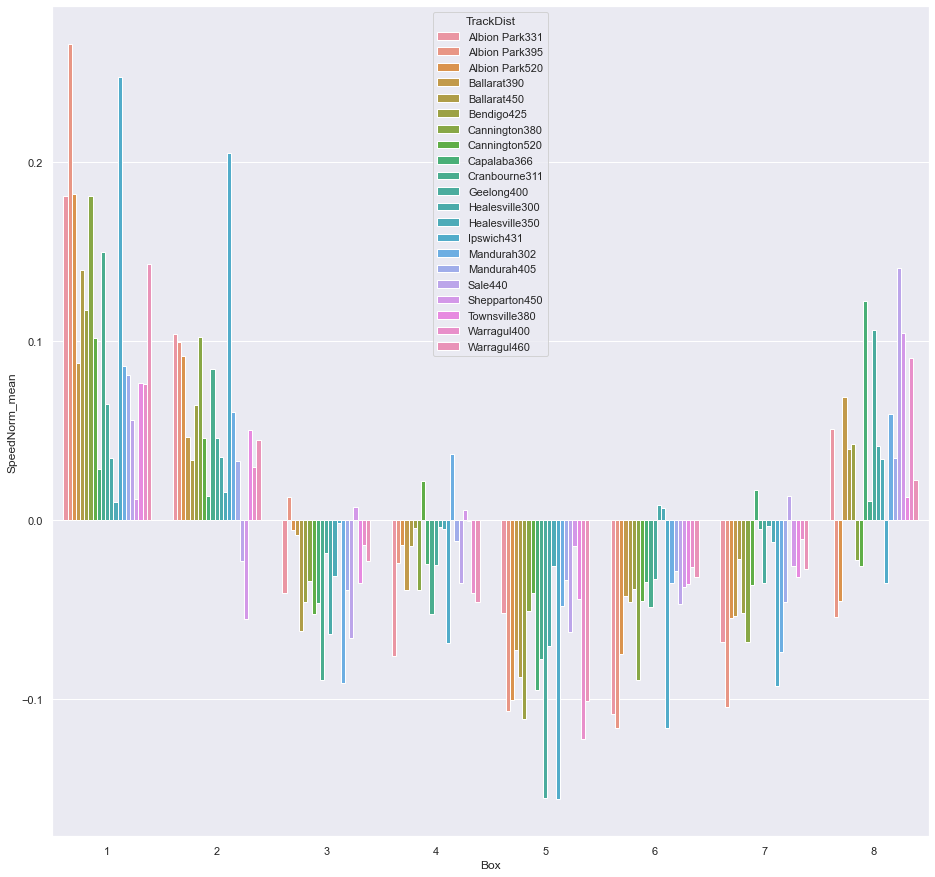

In [11]:
# plot
sns.set_theme()
fig, ax = plt.subplots(figsize=(15.7, 15.27))
plt.rc('xtick',labelsize=15)
plt.rcParams["axes.labelsize"] = 15
plt.rc('ytick',labelsize=15)

sns.barplot(data=df, x="Box", y="SpeedNorm_mean", hue="TrackDist")